In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

Definition of the problem: To develop a dynamic pricing strategy for used phones and tablets to maximize ReCell's competitiveness in the growing market. This involves predicting device prices and identifying key factors influencing pricing.







Loading the Data Set

In [55]:
from google.colab import drive
#access to my drive
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/used_device_data.csv'
df = pd.read_csv(file_path)
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,brand_name,os,screen_size,4g,5g,main_camera_mp,selfie_camera_mp,int_memory,ram,battery,weight,release_year,days_used,normalized_used_price,normalized_new_price
0,Honor,Android,14.50,yes,no,13.0,5.0,64.0,3.0,3020.0,146.0,2020,127,4.307572,4.715100
1,Honor,Android,17.30,yes,yes,13.0,16.0,128.0,8.0,4300.0,213.0,2020,325,5.162097,5.519018
2,Honor,Android,16.69,yes,yes,13.0,8.0,128.0,8.0,4200.0,213.0,2020,162,5.111084,5.884631
3,Honor,Android,25.50,yes,yes,13.0,8.0,64.0,6.0,7250.0,480.0,2020,345,5.135387,5.630961
4,Honor,Android,15.32,yes,no,13.0,8.0,64.0,3.0,5000.0,185.0,2020,293,4.389995,4.947837


Data Overview and Sanity Checks

In [56]:
df.info()
df.describe()
df.isnull()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3454 entries, 0 to 3453
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   brand_name             3454 non-null   object 
 1   os                     3454 non-null   object 
 2   screen_size            3454 non-null   float64
 3   4g                     3454 non-null   object 
 4   5g                     3454 non-null   object 
 5   main_camera_mp         3275 non-null   float64
 6   selfie_camera_mp       3452 non-null   float64
 7   int_memory             3450 non-null   float64
 8   ram                    3450 non-null   float64
 9   battery                3448 non-null   float64
 10  weight                 3447 non-null   float64
 11  release_year           3454 non-null   int64  
 12  days_used              3454 non-null   int64  
 13  normalized_used_price  3454 non-null   float64
 14  normalized_new_price   3454 non-null   float64
dtypes: f

,brand_name,os,screen_size,4g,5g,main_camera_mp,selfie_camera_mp,int_memory,ram,battery,weight,release_year,days_used,normalized_used_price,normalized_new_price
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3449,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False
3450,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3451,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3452,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


Others        502
Samsung       341
Huawei        251
LG            201
Lenovo        171
ZTE           140
Xiaomi        132
Oppo          129
Asus          122
Alcatel       121
Micromax      117
Vivo          117
Honor         116
HTC           110
Nokia         106
Motorola      106
Sony           86
Meizu          62
Gionee         56
Acer           51
XOLO           49
Panasonic      47
Realme         41
Apple          39
Lava           36
Celkon         33
Spice          30
Karbonn        29
Coolpad        22
BlackBerry     22
Microsoft      22
OnePlus        22
Google         15
Infinix        10
Name: brand_name, dtype: int64


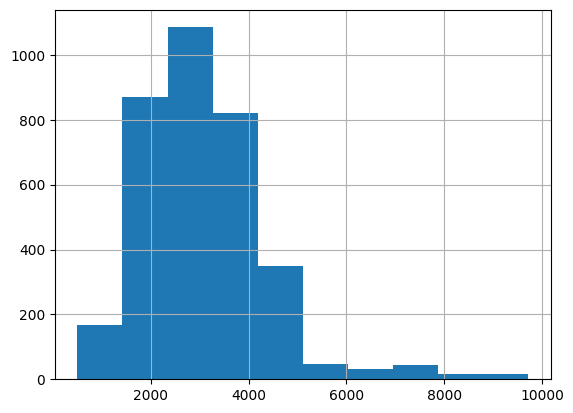

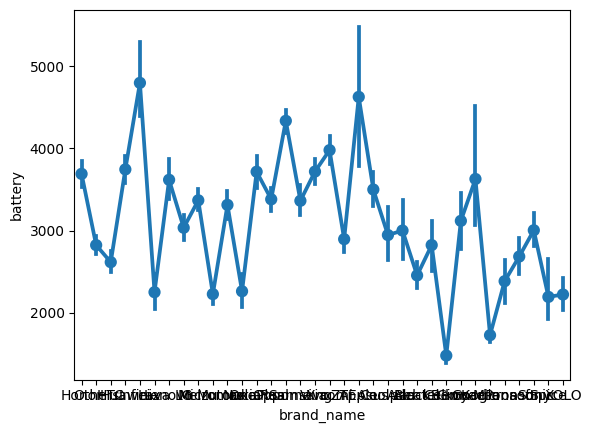

In [57]:
print(df['brand_name'].value_counts())

# Histogram for a numeric column (e.g., 'battery')
df['battery'].hist()
plt.show()

# Box plot for a categorical vs. numeric column (e.g., 'brand_name' vs. 'battery')
sns.pointplot(x='brand_name', y='battery', data=df)
plt.show()

The graph above shows that the top 10 brands with the highest battery levels are Apple, Lenovo, Samsung, Google, Others, Xiaomi, LG, Asus,Spice, Huawei.

In [58]:
top_10_brands = df.sort_values(by='battery', ascending=False).drop_duplicates(subset='brand_name').head(10)
print(top_10_brands[['brand_name', 'battery']])

     brand_name  battery
644       Apple   9720.0
1584     Lenovo   9600.0
2583    Samsung   9500.0
1086     Google   9240.0
3051     Others   9000.0
2937     Xiaomi   8620.0
83           LG   8200.0
731        Asus   7800.0
2781      Spice   7600.0
49       Huawei   7500.0


Checking if Normalized used price, Battery, Internal Memory, and RAM columns are normally distributed

In [59]:
# Assuming 'df' is your DataFrame
columns_to_check = ['normalized_used_price', 'battery', 'int_memory', 'ram']

for column in columns_to_check:
    # Extract the data from the selected column
    data = df[column]

    # Perform the Shapiro-Wilk test for normality
    shapiro_stat, shapiro_p = stats.shapiro(data)

    # Set significance level (e.g., 0.05)
    alpha = 0.05

    # Check if the p-value is less than the significance level
    if shapiro_p > alpha:
        print(f"{column}: Data appears to be normally distributed")
    else:
        print(f"{column}: Data does not appear to be normally distributed")

normalized_used_price: Data does not appear to be normally distributed
battery: Data appears to be normally distributed
int_memory: Data appears to be normally distributed
ram: Data appears to be normally distributed


Exploratory Data Analysis

1. What does the distribution of normalized used device prices look like?

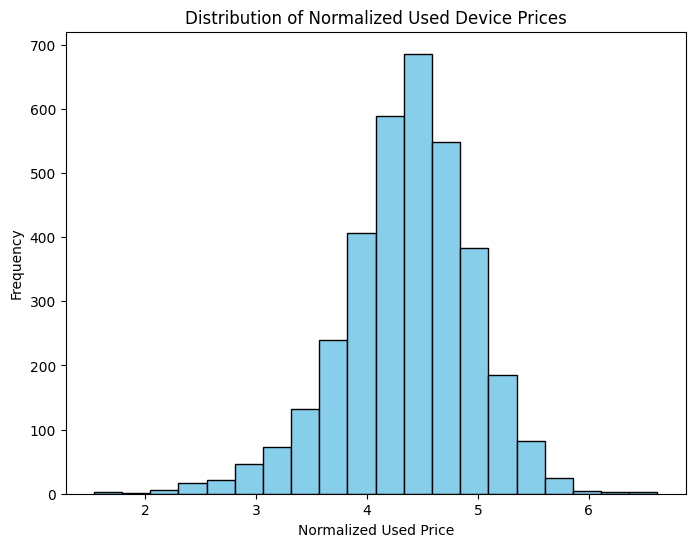

In [60]:
plt.figure(figsize=(8, 6))
plt.hist(df['normalized_used_price'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Normalized Used Price')
plt.ylabel('Frequency')
plt.title('Distribution of Normalized Used Device Prices')
plt.show()

2. What percentage of the used device market is dominated by Android devices?

In [61]:
android_devices = df[df['os'] == 'Android']
percentage_android = (len(android_devices) / len(df)) * 100
print(f"Percentage of Android devices in the market: {percentage_android:.2f}%")


Percentage of Android devices in the market: 93.05%


3. How does the amount of RAM vary with the brand?

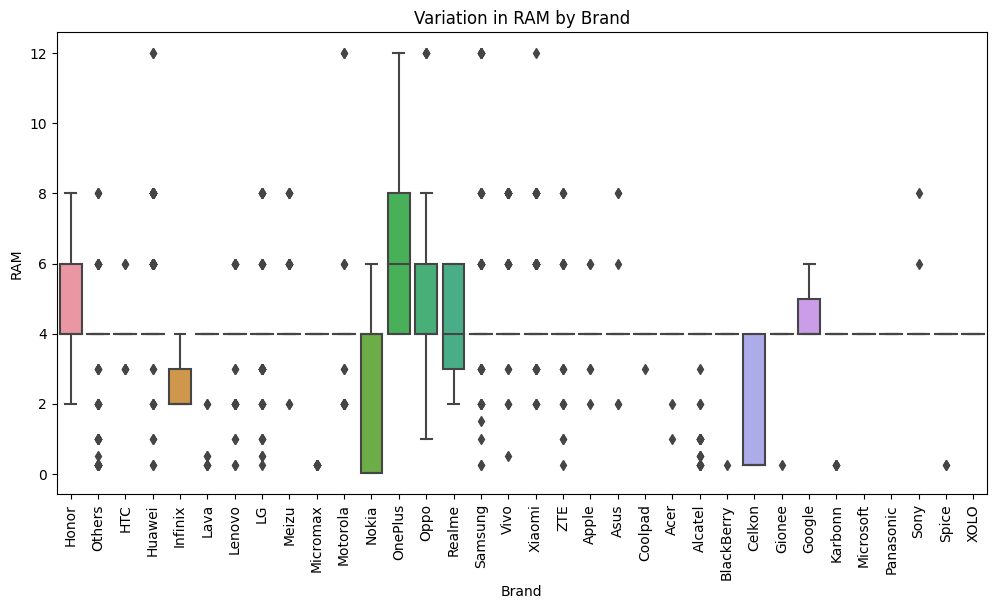

In [62]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='brand_name', y='ram', data=df)
plt.xticks(rotation=90)
plt.xlabel('Brand')
plt.ylabel('RAM')
plt.title('Variation in RAM by Brand')
plt.show()

-The code snippet visualizes the variation in RAM among different device brands using a box plot.

4. How does the weight vary for phones and tablets offering large batteries (more than 4500 mAh)?

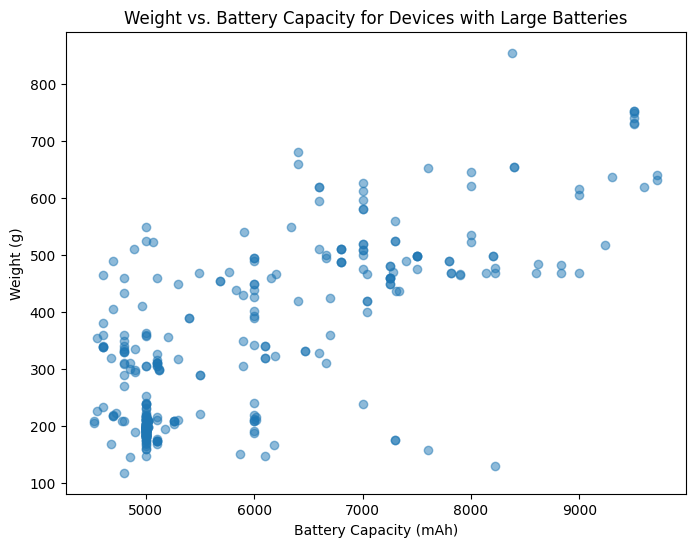

In [63]:
large_battery_devices = df[df['battery'] > 4500]

plt.figure(figsize=(8, 6))
plt.scatter(large_battery_devices['battery'], large_battery_devices['weight'], alpha=0.5)
plt.xlabel('Battery Capacity (mAh)')
plt.ylabel('Weight (g)')
plt.title('Weight vs. Battery Capacity for Devices with Large Batteries')
plt.show()

-The scatter plot illustrates the relationship between the battery capacity (mAh) and the weight (g) of devices with large batteries (more than 4500 mAh), helping to assess the weight impact of larger batteries on phones and tablets.

5. How many phones and tablets are available across different brands with a screen size larger than 6 inches?

In [64]:
large_screen_devices = df[df['screen_size'] > 6]
brand_counts = large_screen_devices['brand_name'].value_counts()

print("Number of devices with a screen size > 6 inches by brand:")
print(brand_counts)

Number of devices with a screen size > 6 inches by brand:
Others        479
Samsung       334
Huawei        251
LG            197
Lenovo        171
ZTE           140
Xiaomi        132
Oppo          129
Asus          122
Vivo          117
Honor         116
Alcatel       115
HTC           110
Micromax      108
Motorola      106
Sony           86
Nokia          72
Meizu          62
Gionee         56
Acer           51
XOLO           49
Panasonic      47
Realme         41
Apple          39
Lava           36
Spice          30
Karbonn        29
Celkon         25
Coolpad        22
OnePlus        22
Microsoft      22
BlackBerry     21
Google         15
Infinix        10
Name: brand_name, dtype: int64


6. What is the distribution of devices offering greater than 8MP selfie cameras across brands?

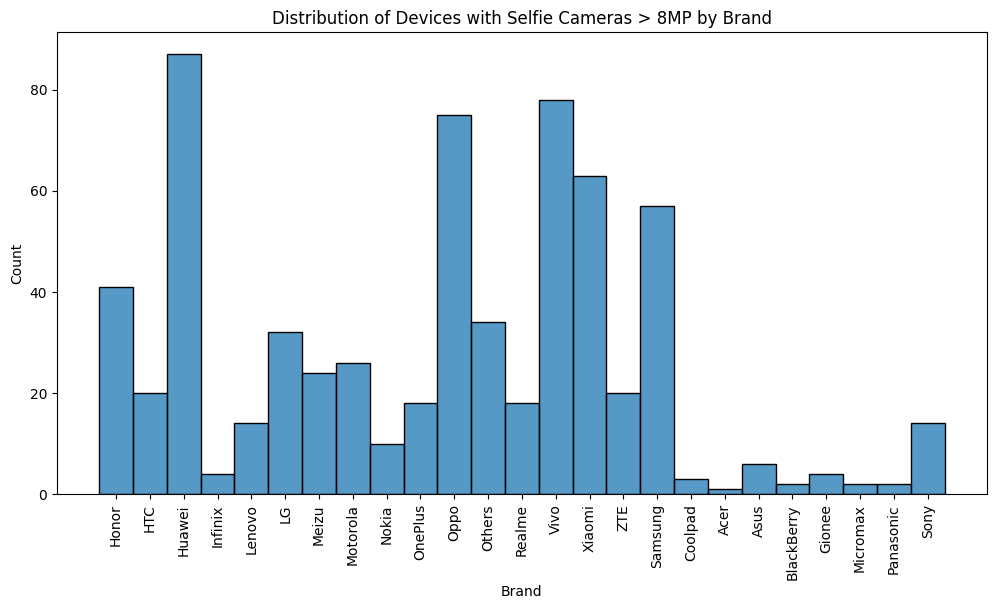

In [65]:
plt.figure(figsize=(12, 6))
sns.histplot(df[df['selfie_camera_mp'] > 8]['brand_name'], bins=len(df['brand_name'].unique()), kde=False)
plt.xticks(rotation=90)
plt.xlabel('Brand')
plt.ylabel('Count')
plt.title('Distribution of Devices with Selfie Cameras > 8MP by Brand')
plt.show()

7. Which attributes are highly correlated with the normalized price of a used device?

<ipython-input-66-8c6bb5cdcc4d>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


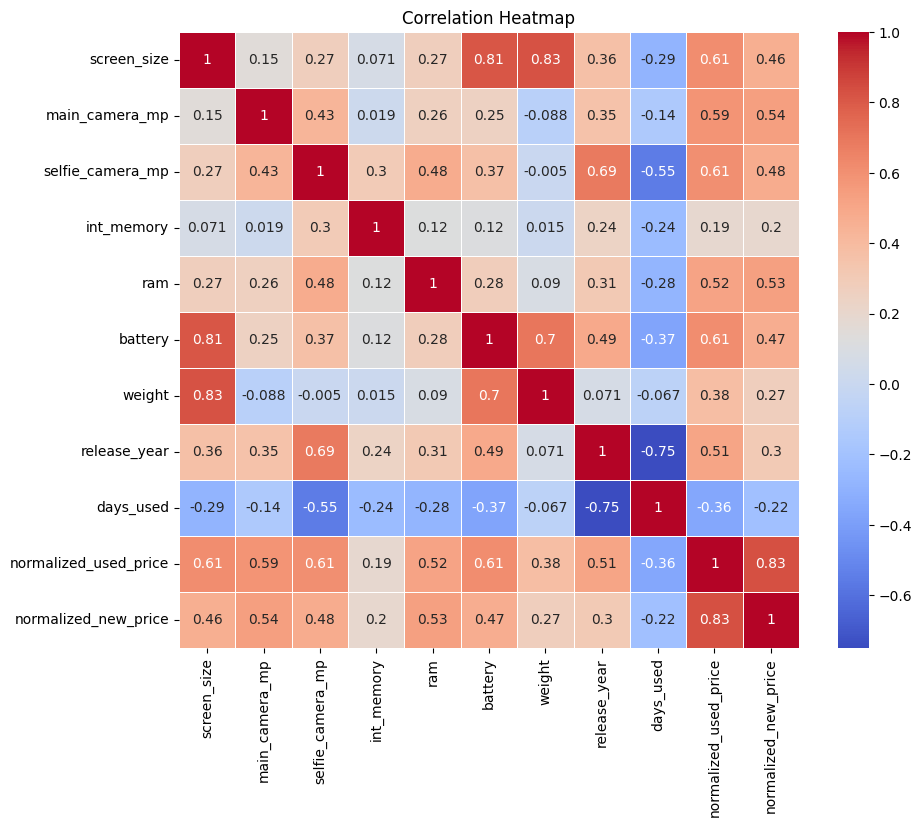

In [66]:
correlation_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

-Normalized used price is highly correlated to normalized new price, screen size, selfie camera, and battery

Data Reprocessing

Creating new Features: Total Camera

In [67]:
df['total_camera_mp'] = df['main_camera_mp'] + df['selfie_camera_mp']

Checking for Outliers

In [68]:
z_scores = stats.zscore(df.select_dtypes(include='number'))
abs_z_scores = np.abs(z_scores)
outliers = (abs_z_scores > 3).any(axis=1)  # Identify rows with at least one outlier
outlier_count = outliers.sum()
print(f"Number of outliers detected using Z-Score: {outlier_count}")

Number of outliers detected using Z-Score: 169


-For my outliers I won't take them out I will just ackowledge them when trying to do the analysis

Creating Dummy Variables

In [69]:
# Create dummy variables for '4g' and '5g'
df_encoded = pd.get_dummies(df, columns=['4g', '5g'])

# Display the resulting DataFrame
print(df_encoded)

     brand_name       os  screen_size  main_camera_mp  selfie_camera_mp  \
0         Honor  Android        14.50            13.0               5.0   
1         Honor  Android        17.30            13.0              16.0   
2         Honor  Android        16.69            13.0               8.0   
3         Honor  Android        25.50            13.0               8.0   
4         Honor  Android        15.32            13.0               8.0   
...         ...      ...          ...             ...               ...   
3449       Asus  Android        15.34             NaN               8.0   
3450       Asus  Android        15.24            13.0               8.0   
3451    Alcatel  Android        15.80            13.0               5.0   
3452    Alcatel  Android        15.80            13.0               5.0   
3453    Alcatel  Android        12.83            13.0               5.0   

      int_memory  ram  battery  weight  release_year  days_used  \
0           64.0  3.0   3020.0  

NEW EDA

In [70]:
print(df.columns)
print(df.describe)


Index(['brand_name', 'os', 'screen_size', '4g', '5g', 'main_camera_mp',
       'selfie_camera_mp', 'int_memory', 'ram', 'battery', 'weight',
       'release_year', 'days_used', 'normalized_used_price',
       'normalized_new_price', 'total_camera_mp'],
      dtype='object')
<bound method NDFrame.describe of      brand_name       os  screen_size   4g   5g  main_camera_mp  \
0         Honor  Android        14.50  yes   no            13.0   
1         Honor  Android        17.30  yes  yes            13.0   
2         Honor  Android        16.69  yes  yes            13.0   
3         Honor  Android        25.50  yes  yes            13.0   
4         Honor  Android        15.32  yes   no            13.0   
...         ...      ...          ...  ...  ...             ...   
3449       Asus  Android        15.34  yes   no             NaN   
3450       Asus  Android        15.24  yes   no            13.0   
3451    Alcatel  Android        15.80  yes   no            13.0   
3452    Alcatel  Andr

Fill in missing values for Battery and Screen Size

In [71]:
df['battery'].fillna(df['battery'].mean(), inplace=True)
df['screen_size'].fillna(df['screen_size'].mean(), inplace=True)
df['selfie_camera_mp'].fillna(df['selfie_camera_mp'].mean(), inplace=True)

Linear Regression

In [72]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Define your features (X) and target variable (y)
X = df[['battery', 'screen_size']]
y = df['normalized_used_price']

# Split the data into a training set and a testing set (adjust test_size as needed)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Linear Regression model
model = LinearRegression()

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Evaluate the model's performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse:.2f}')
print(f'R-squared: {r2:.2f}')

# Use the trained model for predictions (for example, predict the price for a specific battery and screen_size)
new_data = pd.DataFrame({'battery': [3000], 'screen_size': [6.0]})
predicted_price = model.predict(new_data)

print(f'Predicted Price: {predicted_price[0]:.2f}')

Mean Squared Error: 0.20
R-squared: 0.37
Predicted Price: 3.93


The MSE of 0.20 suggests that, on average, my model's predictions have a squared error of 0.20, which may be considered moderate. It indicates that there is room for improvement in the model's accuracy.
The R2 value of 0.37 indicates that the model explains a portion of the variance in 'normalized_used_price,' but there is still unexplained variability. It suggests that other factors beyond 'battery' and 'screen_size' may influence the price.
The predicted price of 3.93 is the model's estimate for a device with the specified characteristics. You can use this estimate as a reference, but keep in mind that it's based on the features included in the model.

Model Performance Check

Mean Squared Error: 0.20
R-squared: 0.37


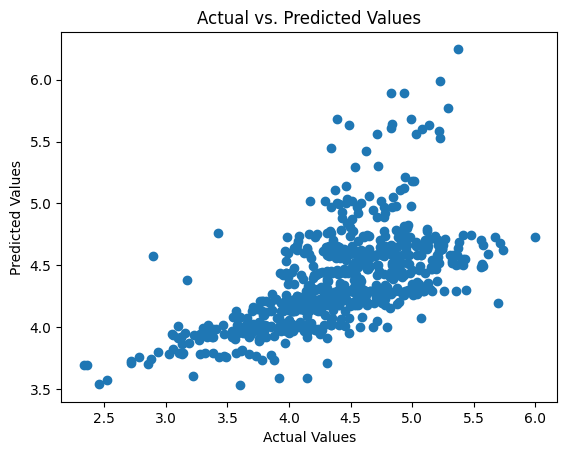

In [73]:
# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse:.2f}')

# Calculate R-squared (R2)
r2 = r2_score(y_test, y_pred)
print(f'R-squared: {r2:.2f}')

# Visualize actual vs. predicted values
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")
plt.show()


Checking Linear Regression Assumptions

Linearity Assumption

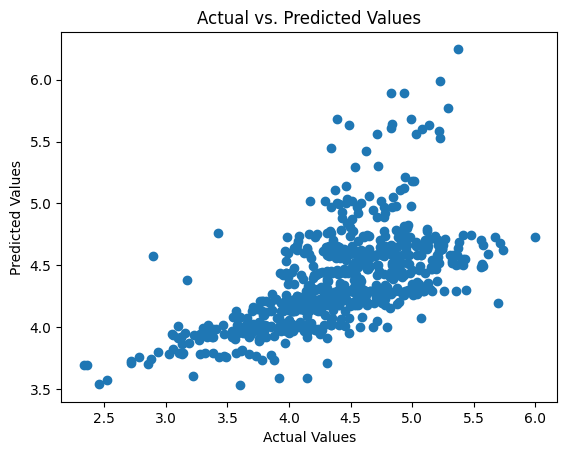

In [74]:
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")
plt.show()

Independence of Errors

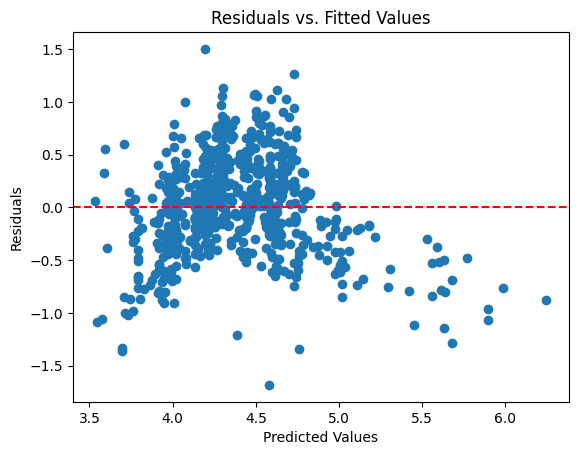

In [75]:
residuals = y_test - y_pred
plt.scatter(y_pred, residuals)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs. Fitted Values")
plt.show()

Homoscedasticity:

Assumption: The variance of the errors should be constant across all levels of the independent variables.
Check: Plot a residuals vs. fitted values plot. The spread of residuals is roughly consistent.

Normality of Residuals

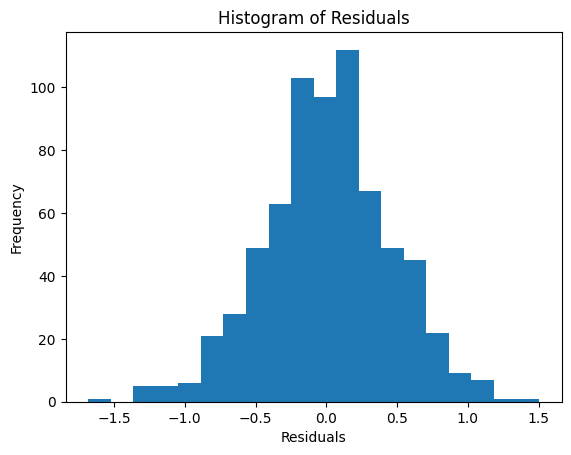

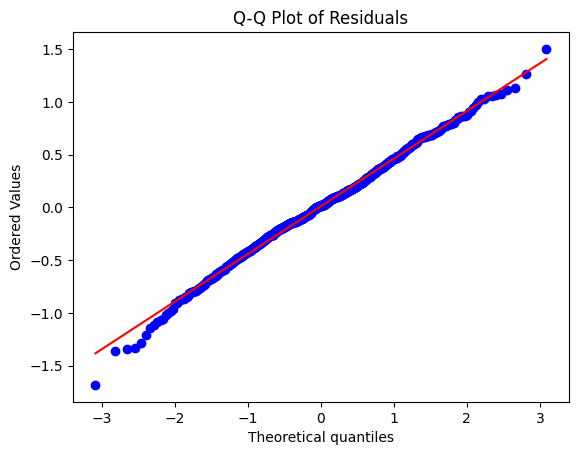

Shapiro-Wilk Statistic: 0.9965471029281616, p-value: 0.1404377967119217


In [76]:

# Histogram of residuals
plt.hist(residuals, bins=20)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Histogram of Residuals")
plt.show()

# Q-Q plot
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()

# Shapiro-Wilk test for normality
shapiro_stat, shapiro_p = stats.shapiro(residuals)
print(f"Shapiro-Wilk Statistic: {shapiro_stat}, p-value: {shapiro_p}")


The Shapiro-Wilk test p-value of 0.1404 suggests that I do not have strong evidence to reject the null hypothesis that the residuals are normally distributed. In other words, the residuals appear to approximately follow a normal distribution. This is a good sign for the normality assumption of linear regression

No or Little Multicollinearity

In [77]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate VIF for each independent variable
vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)

      Variable        VIF
0      battery  18.925404
1  screen_size  18.925404


The VIF values of both 'battery' and 'screen_size' are very high (above 10). High VIF values indicate multicollinearity, which means that these two independent variables are highly correlated with each other. Multicollinearity can be problematic because it can make it challenging to interpret the individual effects of these variables on the dependent variable

FINAL MODEL

Mean Squared Error: 0.14
R-squared: 0.58


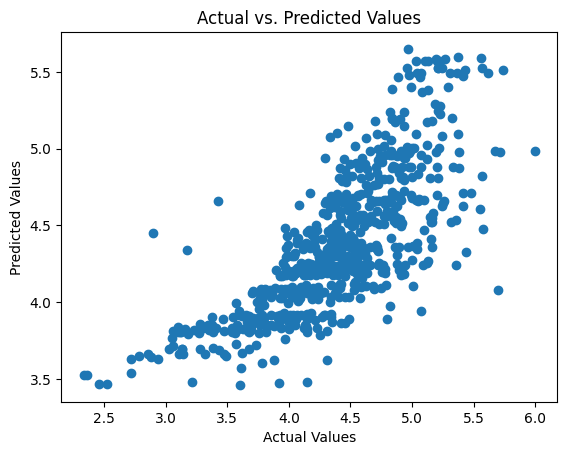

Shapiro-Wilk Statistic: 0.9857, p-value: 0.0000
           Variable        VIF
0           battery  20.304557
1       screen_size  18.933366
2  selfie_camera_mp   2.183141


In [78]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import scipy.stats as stats
from statsmodels.stats.outliers_influence import variance_inflation_factor


# Define your features (X) and target variable (y)
X = df[['battery', 'screen_size', 'selfie_camera_mp']]
y = df['normalized_used_price']

# Split the data into a training set and a testing set (adjust test_size as needed)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Linear Regression model
model = LinearRegression()

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse:.2f}')

# Calculate R-squared (R2)
r2 = r2_score(y_test, y_pred)
print(f'R-squared: {r2:.2f}')

# Visualize actual vs. predicted values
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")
plt.show()

# Check for Normality of Residuals (Shapiro-Wilk test)
residuals = y_test - y_pred
shapiro_stat, shapiro_p = stats.shapiro(residuals)
print(f"Shapiro-Wilk Statistic: {shapiro_stat:.4f}, p-value: {shapiro_p:.4f}")

# Check for Multicollinearity (VIF)
vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)


Insights: The addition of the 'selfie_camera_mp' variable has significantly improved the model's predictive performance. It now explains a larger portion of the variance in 'normalized_used_price' and has a lower mean squared error.

The strong evidence against the normality of residuals may be due to the large sample size. In practice, linear regression is robust to minor deviations from normality, especially with large datasets.

Multicollinearity between 'battery' and 'screen_size' persists, which means their individual contributions to the model may still be challenging to interpret.

Recommendations:

Conduct Competitive Benchmarking: Regularly assess and adjust your pricing strategy by comparing it with competitors in the used device market to maintain a competitive edge without compromising on profitability.

Promote Eco-Friendly Pricing: Integrate the environmental benefits of buying used and refurbished devices into your marketing efforts, emphasizing how purchasing these products helps reduce electronic waste. Offer eco-friendly pricing incentives to attract environmentally-conscious consumers.

Utilize Cross-Selling and Upselling Strategies: Encourage customers to consider related products or higher-priced models by highlighting their enhanced features, such as superior camera quality, larger screen sizes, or faster processors.